In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

DATA_DIR = 'Data/'

In [2]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [3]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
   

# M5 - WRMSSE Evaluation Dashboard

This notebooks shows WRMSSE evaluation Dashboard which I created on the WRMSSEEvaluator class object made by sakami @[Evaluation metric](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834). If you just put the evaluator object into create_dashboard() function in this notebook, it will create the visualizations which give you all the performance details on your created model.

For this demonstration purpose, I'm just developing very simple LGB model using last (112-28) days (3months) in the provided dataset.

-----
Version 3 udates: applied the updated scaling logic in WRMSSEEvaluator from sakami's thread which removes preceding 0 sales from the scale calculation

## Loading Datasets
We are creating two types of sales dataset: "sales" (wide format) and "sales_mlt" (long format). "sales" is used for WRMSSE evaluation, "sales_mlt" is used for LGB training.

In [4]:
train_start=350
valid_end=1941

In [5]:
d_dtypes = {}
for i in range(1942):
    d_dtypes[f'd_{i}'] = np.int32
    
'''
sales = pd.read_csv(DATA_DIR + 'sales_train_validation.csv',
                    dtype=d_dtypes)
'''

sales_df = pd.read_csv('Data/sales_train_evaluation.csv',dtype=d_dtypes)
sales=sales_df[sales_df['cat_id'] =='HOBBIES' ].reset_index()
sales=sales.drop(['index'],axis=1)


# changing wide format to long format for model training


d = ['d_' + str(i) for i in range(train_start,1942)]
sales_mlt = pd.melt(sales, id_vars=['item_id','dept_id','cat_id','store_id',
                                    'state_id'], value_vars=d)
sales_mlt = sales_mlt.rename(columns={'variable':'d', 'value':'sales'})



Merging calendar and prices to the sales_mlt dataset

In [6]:
calendar = pd.read_csv(DATA_DIR + 'calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# subsetting calender by traning period
calendar = calendar.loc[calendar.d.apply(lambda x: int(x[2:])) \
                        >= int(sales_mlt.d[0][2:]), :]

prices = pd.read_csv(DATA_DIR + 'sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})
# subsetting prices by traning period
prices = prices.loc[prices.wm_yr_wk >= calendar.wm_yr_wk.values[0], :]

sales_mlt = sales_mlt.merge(calendar.drop(['date', 'weekday'], axis=1), 
                         how='left', on='d')\
            .merge(prices, how='left', on=['item_id','store_id','wm_yr_wk'])

sales_mlt['snap'] = sales_mlt.apply(lambda x: x.snap_CA if x.state_id == 'CA' \
                              else x.snap_TX if x.state_id == 'TX' \
                              else x.snap_WI, axis=1)
sales_mlt.drop(['snap_CA','snap_TX','snap_WI'], axis=1, inplace=True)

Just adding a few moving avarage to improve the performance a little bit

In [51]:
sales_mlt.loc[:, 'sales_lag1'] = \
    sales_mlt.groupby(['item_id','store_id'])['sales'].shift(periods=1)

sales_mlt.loc[:, 'sales_lag7'] = \
    sales_mlt.groupby(['item_id','store_id'])['sales'].shift(periods=7)

sales_mlt.loc[:, 'sales_lag30'] = \
    sales_mlt.groupby(['item_id','store_id'])['sales'].shift(periods=30)

sales_mlt.loc[:, 'sales_lag90'] = \
    sales_mlt.groupby(['item_id','store_id'])['sales'].shift(periods=90)

grp = sales_mlt.groupby(['item_id','store_id'])

sales_mlt.loc[:,f'sales_lag1_mean7'] = \
    grp['sales_lag1'].transform(lambda x: x.rolling(7).mean())

sales_mlt.loc[:,f'sales_lag7_mean7'] = \
    grp['sales_lag7'].transform(lambda x: x.rolling(7).mean())
sales_mlt.loc[:,f'sales_lag30_mean30'] = \
    grp['sales_lag7'].transform(lambda x: x.rolling(30).mean())


sales_mlt.loc[:,f'sales_lag30_mean7'] = \
    grp['sales_lag30'].transform(lambda x: x.rolling(7).mean())
sales_mlt.loc[:,f'sales_lag30_mean30'] = \
    grp['sales_lag30'].transform(lambda x: x.rolling(30).mean())


sales_mlt.loc[:,f'sales_lag90_mean7'] = \
    grp['sales_lag90'].transform(lambda x: x.rolling(7).mean())
sales_mlt.loc[:,f'sales_lag90_mean30'] = \
    grp['sales_lag90'].transform(lambda x: x.rolling(30).mean())


del grp
gc.collect()

sales_mlt

,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,month,...,snap,sales_lag30,sales_lag30_mean7,sales_lag30_mean30,sales_lag7,sales_lag90,sales_lag7_mean7,sales_lag90_mean7,sales_lag90_mean30,sales_lag1
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_350,0,11150,7,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_350,0,11150,7,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_350,0,11150,7,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_350,2,11150,7,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_350,0,11150,7,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994795,HOBBIES_2_145,HOBBIES_2,HOBBIES,WI_3,WI,d_1941,0,11617,2,5,...,0,0.0,0.571429,0.600000,0.0,0.0,0.142857,0.285714,0.300000,0.0
8994796,HOBBIES_2_146,HOBBIES_2,HOBBIES,WI_3,WI,d_1941,0,11617,2,5,...,0,0.0,0.000000,0.066667,0.0,0.0,0.000000,0.000000,0.066667,0.0
8994797,HOBBIES_2_147,HOBBIES_2,HOBBIES,WI_3,WI,d_1941,0,11617,2,5,...,0,1.0,0.428571,0.766667,0.0,0.0,0.285714,0.285714,0.733333,0.0
8994798,HOBBIES_2_148,HOBBIES_2,HOBBIES,WI_3,WI,d_1941,0,11617,2,5,...,0,0.0,0.000000,0.266667,0.0,0.0,0.000000,0.000000,0.433333,1.0


In [ ]:
sales_mlt.to_csv('Data/sales_mlt.csv')

In [52]:

def train_test_split(sales_mlt,valid_end):
    whole_filter= sales_mlt.d.apply(lambda x: int(x[2:])) <= valid_end
    sub_sales_mlt=sales_mlt.loc[whole_filter, :]
    
    cate_ft_lst = ['item_id','dept_id','cat_id','store_id','state_id','event_name_1',
               'event_type_1','event_name_2','event_type_2']

    X = sub_sales_mlt.drop(['d','sales','wm_yr_wk',], axis=1)
    y = sub_sales_mlt["sales"]
    
    for col in cate_ft_lst:
        le = preprocessing.LabelEncoder()
        X.loc[:, col] = le.fit_transform(X[col].astype(str))
    
    X.fillna(0, inplace=True)
    
    train_end=valid_end-28
    valid_start=train_end+1
    
    train_filter = sub_sales_mlt.d.apply(lambda x: int(x[2:])) <= train_end
    valid_filter = sub_sales_mlt.d.apply(lambda x: int(x[2:])) >= valid_start

    X_train, X_valid = X.loc[train_filter, :], X.loc[valid_filter, :]
    y_train, y_valid = y.loc[train_filter], y.loc[valid_filter]

    print(X_train.shape, X_valid.shape,y_train.shape, y_valid.shape)
    
    return sub_sales_mlt,X_train, X_valid,y_train, y_valid



sub_sales_mlt,X_train, X_valid,y_train, y_valid=train_test_split(sales_mlt,valid_end)

(8836600, 23) (158200, 23) (8836600,) (158200,)


In [67]:
sub_sales_mlt.head(1)

,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,month,...,snap,sales_lag30,sales_lag30_mean7,sales_lag30_mean30,sales_lag7,sales_lag90,sales_lag7_mean7,sales_lag90_mean7,sales_lag90_mean30,sales_lag1
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_350,0,11150,7,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
sub_sales_mlt.tail(1)

,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,month,...,snap,sales_lag30,sales_lag30_mean7,sales_lag30_mean30,sales_lag7,sales_lag90,sales_lag7_mean7,sales_lag90_mean7,sales_lag90_mean30,sales_lag1
8994799,HOBBIES_2_149,HOBBIES_2,HOBBIES,WI_3,WI,d_1941,0,11617,2,5,...,0,0.0,0.285714,0.166667,0.0,1.0,0.285714,0.428571,0.533333,0.0


Converting string into numbers and imputing missing values.

## Model Training
Just creating simple LGB model

In [69]:
lgb_params = {'objective': 'poisson',
              'metric': 'rmse',
              'boosting': 'gbdt',
              'num_leaves': 2**11-1,
              'bagging_fraction': 0.6,
              'bagging_freq': 5,
              'learning_rate': 0.075,
              'n_estimators': 100,
              'min_data_in_leaf':2**12-1
}

model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, verbose=False)
valid_pred = model.predict(X_valid)
gc.collect()

/Users/zlulu/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=4095, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4095
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


52

In [70]:
X_valid

,item_id,dept_id,cat_id,store_id,state_id,wday,month,year,event_name_1,event_type_1,...,snap,sales_lag30,sales_lag30_mean7,sales_lag30_mean30,sales_lag7,sales_lag90,sales_lag7_mean7,sales_lag90_mean7,sales_lag90_mean30,sales_lag1
8836600,0,0,0,0,0,3,4,2016,30,4,...,0,1.0,1.428571,1.133333,1.0,1.0,0.857143,0.714286,0.866667,1.0
8836601,1,0,0,0,0,3,4,2016,30,4,...,0,1.0,0.428571,0.266667,0.0,0.0,0.000000,0.000000,0.100000,0.0
8836602,2,0,0,0,0,3,4,2016,30,4,...,0,1.0,0.285714,0.500000,1.0,0.0,1.285714,0.000000,0.333333,1.0
8836603,3,0,0,0,0,3,4,2016,30,4,...,0,6.0,2.857143,1.866667,4.0,1.0,1.857143,2.428571,1.766667,2.0
8836604,4,0,0,0,0,3,4,2016,30,4,...,0,0.0,1.142857,1.133333,0.0,0.0,0.857143,0.571429,0.566667,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994795,560,1,0,9,2,2,5,2016,30,4,...,0,0.0,0.571429,0.600000,0.0,0.0,0.142857,0.285714,0.300000,0.0
8994796,561,1,0,9,2,2,5,2016,30,4,...,0,0.0,0.000000,0.066667,0.0,0.0,0.000000,0.000000,0.066667,0.0
8994797,562,1,0,9,2,2,5,2016,30,4,...,0,1.0,0.428571,0.766667,0.0,0.0,0.285714,0.285714,0.733333,0.0
8994798,563,1,0,9,2,2,5,2016,30,4,...,0,0.0,0.000000,0.266667,0.0,0.0,0.000000,0.000000,0.433333,1.0


The last 28 days are used for validation. Days before that is used for training

## WRMSSEE Evaluation
Using WRMSSEEvaluator class object from [Evaluation metric](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834) by sakami. I just made some minor changes to use it for the visualization. So, using this class instead of the original one is necessary for the dashboard.

Preparing prediction dataset in wide format, and then evaluating it.

In [71]:
X_train

,item_id,dept_id,cat_id,store_id,state_id,wday,month,year,event_name_1,event_type_1,...,snap,sales_lag30,sales_lag30_mean7,sales_lag30_mean30,sales_lag7,sales_lag90,sales_lag7_mean7,sales_lag90_mean7,sales_lag90_mean30,sales_lag1
0,0,0,0,0,0,7,1,2012,30,4,...,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,1,0,0,0,0,7,1,2012,30,4,...,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,2,0,0,0,0,7,1,2012,30,4,...,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,3,0,0,0,0,7,1,2012,30,4,...,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,4,0,0,0,0,7,1,2012,30,4,...,0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8836595,560,1,0,9,2,2,4,2016,30,4,...,0,0.0,0.285714,0.500000,0.0,0.0,0.428571,0.428571,0.233333,0.0
8836596,561,1,0,9,2,2,4,2016,30,4,...,0,0.0,0.285714,0.166667,0.0,0.0,0.000000,0.000000,0.066667,0.0
8836597,562,1,0,9,2,2,4,2016,30,4,...,0,1.0,0.428571,0.466667,0.0,0.0,0.714286,0.571429,0.633333,2.0
8836598,563,1,0,9,2,2,4,2016,30,4,...,0,0.0,0.142857,0.233333,0.0,1.0,0.000000,0.285714,0.266667,0.0


In [72]:
y_train

0          0
1          0
2          0
3          2
4          0
          ..
8836595    0
8836596    0
8836597    0
8836598    0
8836599    0
Name: sales, Length: 8836600, dtype: int32

In [73]:
def create_evaluation(sales,valid_end, sub_sales_mlt):


    sub_sales=sales.loc[:,:'d_'+str(valid_end)]
    
    train_df = sub_sales.iloc[:, :-28]
    valid_df = sub_sales.iloc[:, -28:]

    return train_df,valid_df

train_df,valid_df=create_evaluation(sales,valid_end, sub_sales_mlt)

In [74]:
train_end=valid_end-28
valid_start=train_end+1
valid_filter = sub_sales_mlt.d.apply(lambda x: int(x[2:])) >= valid_start

valid_pred_df = sub_sales_mlt.loc[valid_filter, ['item_id','store_id', 'd']]
valid_pred_df['pred'] = valid_pred
valid_pred_df = valid_pred_df.set_index(['item_id','store_id','d']).unstack()
valid_pred_df.columns = valid_pred_df.columns.droplevel()
valid_pred_df

d                         d_1914    d_1915    d_1916    d_1917    d_1918  \
item_id       store_id                                                     
HOBBIES_1_001 CA_1      0.936654  0.872406  0.832932  0.847274  0.955371   
              CA_2      0.705175  0.607844  0.692862  0.702899  0.905365   
              CA_3      0.965480  0.948683  0.995251  0.998875  1.074192   
              CA_4      0.792533  0.603988  0.681365  0.658478  0.806347   
              TX_1      0.303088  0.267811  0.270274  0.272491  0.335820   
...                          ...       ...       ...       ...       ...   
HOBBIES_2_149 TX_2      0.462055  0.616752  0.403655  0.595446  0.584493   
              TX_3      0.410519  0.373613  0.499462  0.338255  0.359476   
              WI_1      0.353452  0.261014  0.254281  0.258681  0.313446   
              WI_2      0.122258  0.121323  0.122347  0.123393  0.116406   
              WI_3      0.288804  0.246177  0.347870  0.345815  0.370944   

d                         d_1919    d_1920    d_1921    d_1922    d_1923  ...  \
item_id       store_id                                                    ...   
HOBBIES_1_001 CA_1      0.992608  1.041917  0.804458  0.692263  0.645894  ...   
              CA_2      1.109923  1.164122  0.757716  0.771176  0.700315  ...   
              CA_3      1.280251  1.306397  1.192913  1.046623  1.087832  ...   
              CA_4      1.059997  1.001529  0.855122  0.775663  0.751765  ...   
              TX_1      0.368035  0.399795  0.281625  0.261497  0.282349  ...   
...                          ...       ...       ...       ...       ...  ...   
HOBBIES_2_149 TX_2      0.643808  0.518152  0.720862  0.644078  0.884826  ...   
              TX_3      0.405606  0.443890  0.376854  0.377827  0.369649  ...   
              WI_1      0.268082  0.386971  0.290040  0.210794  0.206669  ...   
              WI_2      0.140988  0.130803  0.158571  0.204936  0.159128  ...   
              WI_3      0.383281  0.331616  0.298538  0.360471  0.297193  ...   

d                         d_1932    d_1933    d_1934    d_1935    d_1936  \
item_id       store_id                                                     
HOBBIES_1_001 CA_1      1.041142  1.242312  1.046104  0.903002  0.823651   
              CA_2      0.608934  0.772891  0.656639  0.488237  0.476806   
              CA_3      0.958815  1.247668  1.197361  1.000141  0.982467   
              CA_4      0.690630  0.895915  0.882996  0.746242  0.684530   
              TX_1      0.241247  0.337233  0.325862  0.270377  0.279481   
...                          ...       ...       ...       ...       ...   
HOBBIES_2_149 TX_2      0.718432  0.802169  0.684483  0.499280  0.573407   
              TX_3      0.528849  0.488719  0.277332  0.366146  0.347824   
              WI_1      0.420406  0.350555  0.271498  0.409521  0.291452   
              WI_2      0.380053  0.415904  0.395735  0.303890  0.299015   
              WI_3      0.324708  0.501625  0.489150  0.328455  0.276643   

d                         d_1937    d_1938    d_1939    d_1940    d_1941  
item_id       store_id                                                    
HOBBIES_1_001 CA_1      0.817440  0.800488  1.044894  1.526137  1.197035  
              CA_2      0.517841  0.554654  0.728373  0.941238  0.955542  
              CA_3      0.864105  0.906937  1.079666  1.389097  1.262620  
              CA_4      0.640217  0.613265  0.720851  0.760973  0.800273  
              TX_1      0.307191  0.269925  0.367795  0.387825  0.363429  
...                          ...       ...       ...       ...       ...  
HOBBIES_2_149 TX_2      0.620010  0.635177  0.684700  0.756105  0.704164  
              TX_3      0.495406  0.591864  0.622095  0.620093  0.600815  
              WI_1      0.356296  0.352638  0.357905  0.382256  0.419839  
              WI_2      0.208334  0.368839  0.207869  0.631303  0.217524  
              WI_3      0.434776  0.213482  0.266047  0.303461  0.27

In [75]:
sub_sales=sales.loc[:,:'d_'+str(valid_end)]
valid_cols = list(sub_sales.columns[-28:])
valid_pred_df = valid_pred_df.loc[zip(sub_sales.item_id, sub_sales.store_id), valid_cols]
valid_pred_df

,d,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,store_id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001,CA_1,0.936654,0.872406,0.832932,0.847274,0.955371,0.992608,1.041917,0.804458,0.692263,0.645894,...,1.041142,1.242312,1.046104,0.903002,0.823651,0.817440,0.800488,1.044894,1.526137,1.197035
HOBBIES_1_002,CA_1,0.184280,0.194313,0.283768,0.229926,0.262301,0.334805,0.332105,0.211071,0.217084,0.209090,...,0.183870,0.221193,0.240184,0.186118,0.163429,0.167531,0.157313,0.187405,0.243570,0.247088
HOBBIES_1_003,CA_1,0.663233,0.530486,0.538677,0.600384,0.543470,0.617938,0.702570,0.460638,0.387287,0.264873,...,0.294670,0.450984,0.486715,0.545908,0.414524,0.449832,0.467716,0.672808,0.718596,0.653958
HOBBIES_1_004,CA_1,1.759908,1.634348,1.343225,1.507539,1.808269,2.818555,2.512432,1.722677,1.704605,1.649931,...,2.129163,2.813041,2.758855,1.552469,1.638291,1.540283,1.694054,1.966010,2.114834,2.227871
HOBBIES_1_005,CA_1,0.852565,0.837656,0.773346,0.918781,1.100005,1.434602,1.399627,1.279538,1.152547,1.191787,...,1.306607,1.417943,1.493457,1.128753,1.106381,1.082069,1.055790,1.110670,1.504869,1.427007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOBBIES_2_145,WI_3,0.213732,0.205914,0.207043,0.357883,0.392765,0.413656,0.386558,0.432371,0.339776,0.353749,...,0.388152,0.456775,0.390021,0.366768,0.353713,0.415107,0.327824,0.370462,0.456749,0.328647
HOBBIES_2_146,WI_3,0.137767,0.124430,0.125842,0.136428,0.140590,0.179275,0.208322,0.134979,0.161183,0.156329,...,0.169151,0.167010,0.161535,0.151778,0.127611,0.130098,0.106903,0.115659,0.098192,0.095393
HOBBIES_2_147,WI_3,0.437421,0.485195,0.525688,0.456762,0.591129,0.697445,0.562221,0.461542,0.507587,0.561766,...,0.486823,0.632520,0.742158,0.556008,0.449991,0.449503,0.515187,0.624360,0.547699,0.515206


In [76]:
train_df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,HOBBIES_2_145_WI_3_evaluation,HOBBIES_2_145,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
5646,HOBBIES_2_146_WI_3_evaluation,HOBBIES_2_146,HOBBIES_2,HOBBIES,WI_3,WI,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5647,HOBBIES_2_147_WI_3_evaluation,HOBBIES_2_147,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,...,1,0,0,0,0,2,0,1,2,0
5648,HOBBIES_2_148_WI_3_evaluation,HOBBIES_2_148,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [77]:
valid_df

,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,0,0,2,0,3,5,0,0,1,...,2,4,0,0,0,0,3,3,0,1
1,0,1,0,0,0,0,0,0,0,1,...,0,1,2,1,1,0,0,0,0,0
2,0,0,1,1,0,2,1,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,0,0,1,2,4,1,6,4,0,0,...,1,1,0,4,0,1,3,0,2,6
4,1,0,2,3,1,0,3,2,3,1,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
5646,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5647,1,2,1,2,2,0,0,0,1,0,...,0,2,0,0,0,1,2,0,0,0
5648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,1,0


In [78]:
valid_pred_df

,d,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,store_id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001,CA_1,0.936654,0.872406,0.832932,0.847274,0.955371,0.992608,1.041917,0.804458,0.692263,0.645894,...,1.041142,1.242312,1.046104,0.903002,0.823651,0.817440,0.800488,1.044894,1.526137,1.197035
HOBBIES_1_002,CA_1,0.184280,0.194313,0.283768,0.229926,0.262301,0.334805,0.332105,0.211071,0.217084,0.209090,...,0.183870,0.221193,0.240184,0.186118,0.163429,0.167531,0.157313,0.187405,0.243570,0.247088
HOBBIES_1_003,CA_1,0.663233,0.530486,0.538677,0.600384,0.543470,0.617938,0.702570,0.460638,0.387287,0.264873,...,0.294670,0.450984,0.486715,0.545908,0.414524,0.449832,0.467716,0.672808,0.718596,0.653958
HOBBIES_1_004,CA_1,1.759908,1.634348,1.343225,1.507539,1.808269,2.818555,2.512432,1.722677,1.704605,1.649931,...,2.129163,2.813041,2.758855,1.552469,1.638291,1.540283,1.694054,1.966010,2.114834,2.227871
HOBBIES_1_005,CA_1,0.852565,0.837656,0.773346,0.918781,1.100005,1.434602,1.399627,1.279538,1.152547,1.191787,...,1.306607,1.417943,1.493457,1.128753,1.106381,1.082069,1.055790,1.110670,1.504869,1.427007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOBBIES_2_145,WI_3,0.213732,0.205914,0.207043,0.357883,0.392765,0.413656,0.386558,0.432371,0.339776,0.353749,...,0.388152,0.456775,0.390021,0.366768,0.353713,0.415107,0.327824,0.370462,0.456749,0.328647
HOBBIES_2_146,WI_3,0.137767,0.124430,0.125842,0.136428,0.140590,0.179275,0.208322,0.134979,0.161183,0.156329,...,0.169151,0.167010,0.161535,0.151778,0.127611,0.130098,0.106903,0.115659,0.098192,0.095393
HOBBIES_2_147,WI_3,0.437421,0.485195,0.525688,0.456762,0.591129,0.697445,0.562221,0.461542,0.507587,0.561766,...,0.486823,0.632520,0.742158,0.556008,0.449991,0.449503,0.515187,0.624360,0.547699,0.515206


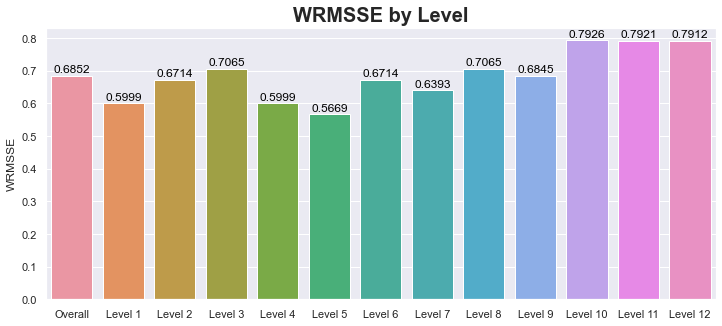

In [79]:
evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, prices)
WRMSSEE = evaluator.score(valid_pred_df.values)
#sub_sales,train_df,valid_df,valid_pred_df=create_wrmsse(sales,valid_end,valid_pred,sub_sales_mlt)
create_dashboard(evaluator)

In [22]:
valid_pred_df_CNN=pd.read_csv('Data/CNN_LSTM.csv')
valid_pred_df_CNN=valid_pred_df_CNN.drop(['Unnamed: 0'],axis=1)
valid_pred_df_CNN

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,0.848520,0.726245,0.796682,0.856834,0.915271,1.180801,1.107124,0.858981,0.842145,0.724602,...,0.814311,1.117373,1.039033,0.674366,0.671465,0.704655,0.717372,0.880975,1.086777,0.864458
1,0.029853,0.073545,0.121448,0.146427,0.179988,0.189901,0.135219,0.084950,0.115214,0.176594,...,0.138809,0.291980,0.233404,0.136282,0.115132,0.141287,0.123560,0.246095,0.257008,0.180556
2,0.250662,0.193326,0.273558,0.304309,0.362993,0.545878,0.436637,0.271150,0.197003,0.188702,...,0.220671,0.502800,0.410358,0.076104,0.070843,0.137818,0.121266,0.300911,0.460961,0.257794
3,1.985972,1.382264,1.600734,1.725962,1.899926,3.126510,3.003216,1.762248,1.944874,1.500505,...,2.120581,2.855081,3.043343,1.828690,1.590211,1.751001,1.770517,2.644287,3.753302,3.199709
4,1.153113,1.211966,1.185419,1.309966,1.468451,1.793642,1.690053,1.364443,1.380938,1.242896,...,1.305276,1.761429,1.713572,1.142265,1.139484,1.166666,1.207572,1.548159,1.948611,1.635313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,0.080689,0.155293,0.070935,0.152758,0.168025,0.070099,0.046536,0.154579,0.091833,0.036563,...,0.134618,0.212179,0.072280,0.080364,0.121929,0.053097,0.161027,0.113374,0.095309,0.045958
5646,0.151312,0.128973,0.112534,0.103097,0.047069,0.000000,0.073705,0.055039,0.081912,0.055524,...,0.140563,0.057294,0.069769,0.062063,0.076098,0.125215,0.097351,0.090766,0.111404,0.135388
5647,0.842527,0.827272,0.766599,0.559090,0.765883,0.770649,0.771269,0.809106,0.740294,0.755936,...,0.682356,0.794629,0.811624,0.692857,0.604500,0.778298,0.735245,0.726382,0.790564,0.683393
5648,0.271976,0.325190,0.271332,0.271247,0.293958,0.268471,0.323524,0.269206,0.322963,0.325978,...,0.245283,0.478180,0.402085,0.260912,0.274635,0.226720,0.254833,0.358099,0.441355,0.294599


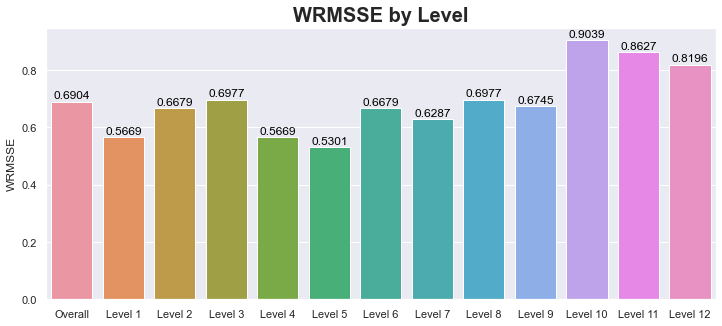

In [23]:
#CNN
evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, prices)
WRMSSEE = evaluator.score(valid_pred_df_CNN.values)
#sub_sales,train_df,valid_df,valid_pred_df=create_wrmsse(sales,valid_end,valid_pred,sub_sales_mlt)
create_dashboard(evaluator)

In [24]:
wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

## WRMSSE by Level
'''
plt.figure(figsize=(12,5))
ax = sns.barplot(x=labels, y=wrmsses)
ax.set(xlabel='', ylabel='WRMSSE')
plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
for index, val in enumerate(wrmsses):
    ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
'''
for index, val in enumerate(wrmsses):
    print(index,val)

0 0.6903671638294799
1 0.5668656426112547
2 0.6678781793631868
3 0.6976866032601319
4 0.5668656426112547
5 0.5300881175119295
6 0.6678781793631868
7 0.6287023232967384
8 0.6976866032601319
9 0.6745136208833973
10 0.9039321740018569
11 0.862686697328459
12 0.8196221824622322


In [25]:
evaluator.all_scores

[0.5668656426112547,
 0.6678781793631868,
 0.6976866032601319,
 0.5668656426112547,
 0.5300881175119295,
 0.6678781793631868,
 0.6287023232967384,
 0.6976866032601319,
 0.6745136208833973,
 0.9039321740018569,
 0.862686697328459,
 0.8196221824622322]

In [26]:
sales
#sub_sales
#sub_sales_mlt
#sales_mlt 都是这个格式

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,HOBBIES_2_145_WI_3_evaluation,HOBBIES_2_145,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5646,HOBBIES_2_146_WI_3_evaluation,HOBBIES_2_146,HOBBIES_2,HOBBIES,WI_3,WI,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5647,HOBBIES_2_147_WI_3_evaluation,HOBBIES_2_147,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,0,...,0,2,0,0,0,1,2,0,0,0
5648,HOBBIES_2_148_WI_3_evaluation,HOBBIES_2_148,HOBBIES_2,HOBBIES,WI_3,WI,0,0,0,1,...,0,0,0,0,1,2,0,0,1,0


## Creating Dashboard
The dashboard shows WRMSSE at each aggregation level (12 levels total) in the top. In the following sections, it shows RMSSE and weights on each component at each aggregation level along with time series visualizations on each corresponding element. As level 7-12 have too many elements to show the time series viz, it just shows the first 9 elements on each level. Please note the weights shown in this viz is level-wise weights not divided by the number of levels (12).

If you are not familiar with the evaluation metric, you can find all the details in [the official doc](https://mk0mcompetitiont8ake.kinstacdn.com/wp-content/uploads/2020/02/M5-Competitors-Guide_Final-1.pdf).

The function below (create_dashboard) just accepts evaluator class object from WRMSSEEvaluator and it will create all the visualizations for you.

In [27]:
#valid_pred = model.predict(X_valid)